In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns

The data set is loaded here

In [87]:
#Load the dataset
data = pd.read_csv("ecoli.csv")

#Check number of rows and columns in the dataset
ncol = len(data.columns)
nrows = len(data.index)

print("The Ecoli dataset consists of", nrows, "rows and", ncol, "columns.")

The Ecoli dataset consists of 129 rows and 6 columns.


Before putting the data into the models, some exploratory data analysis needs to be done. This section covers the EDA stage of the assignment.

In [88]:
data.head()

,X1,X2,X3,X4,X5,C
0,-0.007564,0.222171,0.158978,1.159728,0.267387,0
1,0.171858,-0.041690,0.250635,0.165851,0.461043,0
2,0.736046,0.343963,0.749114,0.561858,0.712554,0
3,0.000639,-0.175082,0.070584,0.317284,0.582597,0
4,0.571760,-0.244216,0.234515,0.902095,0.594026,0


In [89]:
#Count values in each class of the dependent variable
(data["C"]).value_counts()

0    77
1    52
Name: C, dtype: int64

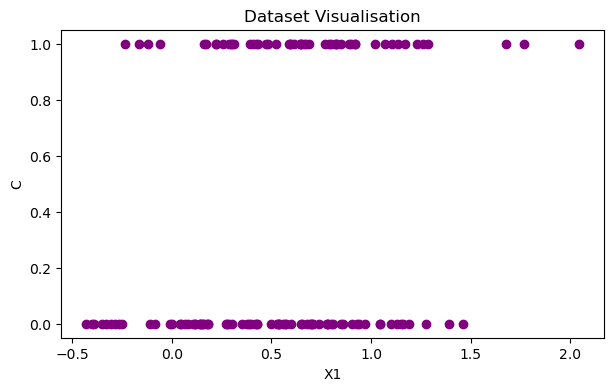

In [90]:
#Visualise the data
#Reference [1]
plt.figure(figsize = (7, 4))
plt.scatter(x="X1", y="C", data=data, color="purple")
plt.xlabel("X1")
plt.ylabel("C")
plt.title("Dataset Visualisation")

plt.show()

The dataset appears to be balanced.
From the view of the dataset, the column used for prediction looks like it has most rows with class '0' at the top of the dataframe, and values with '1' the bottom. So the dataset would be randomized for sufficient reresentation from both classes for training.


In [121]:
#Randomise and reorder the randomised dataset
#Reference [2]

sampled_data = data.sample(frac = 1) #Randomise dataset
reordered_data = sampled_data.reset_index(drop=True) #Re-order data
reordered_data.head()

,X1,X2,X3,X4,X5,C
0,0.538735,0.862264,1.128815,0.870616,0.994083,0
1,1.675908,-0.177512,0.560471,0.231030,0.621173,1
2,1.102461,0.854156,0.316743,0.289436,0.058562,1
3,0.599831,0.523436,0.900913,0.534362,0.957515,0
4,1.159715,0.484991,0.718067,0.624116,0.778146,0


In [122]:
#Split dataset

split= round(nrows * 0.7) #Split the dataset into 70% training and 30% testing
train = reordered_data.iloc[:split] #Training data
test = reordered_data.iloc[split:] #Testing data

In [123]:
#Train and test data are broken down into 2 dataframes each - 
#1 for the independent variables/features, the other for the dependent variable/output
#Reference [3]

train_in = train.iloc[:,0:ncol-1] #Training data features
train_out = train.iloc[:,-1] #Training data output
test_in = test.iloc[:,0:ncol-1] #Testing data features
test_out = test.iloc[:,-1] #Testing data output

# Predictions

A value of 0 refers to proteins located in the inner membrane.
A value of 1 refers to proteins located in the perisplasm.

In this section, variables starting with "Reg" represent the logistic regression, and variables starting with "NB" represent the Naive Bayes. Variations of these variables will be used for modelling and performance evaluations.

## Naive Baye's Classification

Naïve Baye’s classifier is a classification method that adopts the Baye’s theorem. It has 3 types: Gaussian which is mainly used for continuous values, Multinomial which is mainly used for text classification, and Bernoulli for binary classification e.g. 0 or 1.
It is calculated using the formula: 
$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$
Where $$P(B|A)$$ is the likelihood,

$$P(A|B)$$ is the posterior,

and $$P(A)$$ is the prior. #Reference [4]

It works on the assumption that each feature/variable is independent.
Using the dataset: 
$$P(C|X1, X2, \ldots, X5) = \frac{P(X1, X2, \ldots, X5|C) \cdot P(C)}{P(X1, X2, \ldots, X5)}
$$
Therefore, the assumption in the above equation is: 
$$P(X1, X2, \ldots, X5|C) = P(X1|C) \cdot P(X2|C) \cdot \ldots \cdot P(X5|C).
$$

$$P(C)$$ is known as the “prior”. It is the probability of the each class in the dependent variable from the dataset, given as $$ P(C=0) = \frac{\text{Total number of occurrences of "0"}}{\text{Total number of rows in the dataset}}
$$

It makes use of assumptions that may not always hold. This is a major disadvantage of this classification method.

The output of the dataset is binary, and the Bernoulli Naive Bayes model should typically be used. However, the Gaussian Naive Bayes model is used because it is more suited for continuous features, and is able to handle a wide range of data distributions.

In [124]:
#Application of the Gaussian Naive Bayes model
#Reference [5]

NB_model = GaussianNB()
NB_model.fit(train_in, train_out)

GaussianNB()

In [125]:
#Making predictions on the test dataframe

NB_predictions = NB_model.predict(test_in)
NB_predictionstrain = NB_model.predict(train_in)

## Logistic Regression

Logistic regression estimates the probability of occurrence of the dependent/output variable.
It uses a function called the logistic or sigmoid function to map the independent variables to the dependent variables (0 or 1). It is denoted by:
$$P(X=0)=\frac{1}{1 + e^{-x}}$$
Where $$P(X=0)$$ is the probability that the dependent variable is 0,
$$e$$ is the base of the natural logarithm,


And x is the linear regression equation $$(m_i x_i+m_0)$$ where $$m_i$$ is the coefficient of the line, and $$m_0$$ is the intercept (also a coefficient).

Using the dataset, the logistic function is:
$$
\frac{1}{1 + e^{-(m_0 + m_1 \cdot X1 + m_2 \cdot X2 + \ldots + m_5 \cdot X5)}}
$$

The coefficients need to be determined to ensure that the data is well represented. The optimal values of these coefficients are computed using the Maximum Likelihood Estimate (MLE).
The MLE maximises the likelihood function. The likelihood function is the product of the individual probabilities of observing the given outcomes in the logistic model. This could also be the Probability Density Function (PDF) for continuous random variables, or Probability Mass Function (PMF) for discrete random variables. The function is given by:
$$L=\prod_{i=1}^{n} P_i^{y_i} \cdot (1 - P_i)^{1-y_i}$$

The log likelihood is often used to simplify the likelihood function. It is calculated by computing the log of the likelihood function: $$log(⁡L)$$.

The maximisation of this likelihood function can be done either graphically, using calculus, or using optimisation algorithms like the gradient descent.
Once the likelihood function has been maximised, then the model has been trained and fitted to the dataset. After this, predictions can be made on unseen data, and the model’s performance can then be evaluated using metrics like precision, accuracy, F1 score, etc.


In [126]:
#Application of the Logistic Regression model
#Reference [6]

Reg_model = LogisticRegression()
Reg_model.fit(train_in, train_out)

LogisticRegression()

In [127]:
#Making predictions on the test dataframe

Reg_predictions = Reg_model.predict(test_in)
Reg_predictionstrain = Reg_model.predict(train_in)

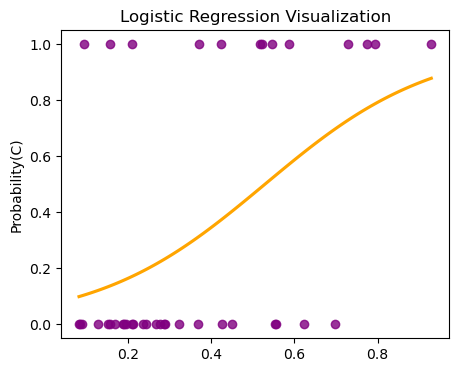

In [128]:
#Visualisation of the Logistic Regression using the prediction probabilities
#Reference [11]

Reg_probabilities = Reg_model.predict_proba(test_in)[:,1]

plt.figure(figsize = (5, 4))

sns.regplot(x = Reg_probabilities, y = test_out, logistic = True, ci = None, 
            scatter_kws = {'color': 'purple'}, line_kws = {'color': 'orange'})
plt.ylabel("Probability(C)")
plt.xlabel("")
plt.title("Logistic Regression Visualization")
plt.show()

# Evaluations

## Accuracy

It is commonly used to measure a model's performance by measuring the correctness of predictions. It is good for balanced datasets; hence why it is used to evaluate the performance of the Logistic Regression and Naive Bayes classifiers in this assignment. The higher the accuracy, the better the performance of the model. A disadvantage of accuracy as a performance measure is that it does not provide insights on the type of errors made by the model. For example: True negative, False positive. Accuracy is given by:  
$$\text{Accuracy} = \frac{\text{Total number of correct predictions}}{\text{Total number of predictions}}$$

In [129]:
#Accuracy score on the models
#Reference [7]

NB_accuracy = accuracy_score(test_out, NB_predictions)
Reg_accuracy = accuracy_score(test_out, Reg_predictions)
print("The accuracy of the Naive Bayes model is", round(NB_accuracy,2))
print("The accuracy of the Logistic Regression model is", round(Reg_accuracy,2))

The accuracy of the Naive Bayes model is 0.72
The accuracy of the Logistic Regression model is 0.77


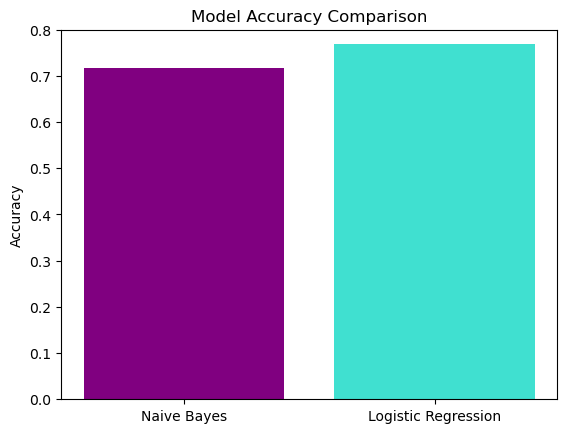

In [130]:
#Visualisation of the accuracy
#Bar chart

models = ['Naive Bayes', 'Logistic Regression']
accuracies = [NB_accuracy, Reg_accuracy]

plt.bar(models, accuracies, color=['purple', 'turquoise'])
plt.ylim(0, 0.8)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

## CONFUSION MATRIX

In [131]:
print("\033[1m Logistic RegressionClassification Report:\033[0m\n", classification_report(test_out, Reg_predictions))
print("\033[1m Naive BayesClassification Report:\033[0m\n", classification_report(test_out, NB_predictions))

 Logistic RegressionClassification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.67      0.62      0.64        13

    accuracy                           0.77        39
   macro avg       0.74      0.73      0.74        39
weighted avg       0.77      0.77      0.77        39

 Naive BayesClassification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.60      0.46      0.52        13

    accuracy                           0.72        39
   macro avg       0.68      0.65      0.66        39
weighted avg       0.71      0.72      0.71        39



In [132]:
#Confusion Matrix
NB_ConfusionMatrix = confusion_matrix(test_out, NB_predictions)
Reg_ConfusionMatrix = confusion_matrix(test_out, Reg_predictions)
print("Naive Bayes Confusion Matrix", NB_ConfusionMatrix)
print("Logistic Regression Confusion Matrix", Reg_ConfusionMatrix)

Naive Bayes Confusion Matrix [[22  4]
 [ 7  6]]
Logistic Regression Confusion Matrix [[22  4]
 [ 5  8]]


## F1 SCORE

F1 score is also used to evaluate classification models' performances, specifically imbalanced datasets. It is a combination of precision and recall and provides a balanced measure of how effectively a model can accurately make positive predictions.
It is denoted by: 
    $$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$
Precision measures the accuracy of positive predictions.
Recall measures the model’s ability to capture all positive instances of the prediction.
The F1 score ranges from 0 to 1. A higher F1 score means a better performance of the model.


In [133]:
#F1 Score of the models
#Reference [7]

NB_F1 = f1_score(test_out, NB_predictions)
Reg_F1 = f1_score(test_out, Reg_predictions)
print("Naive Bayes F1 score", round(NB_F1,2))
print("Logistic Regression F1 score", round(Reg_F1,2))

Naive Bayes F1 score 0.52
Logistic Regression F1 score 0.64


## ROC

This is a graph that shows the performance of a classification model at all classification thresholds. It plots the true positive rate (sensitivity/recall) against the false positive rate (1-specificity/precision). It is a good metric to evaluate the performance of probabilistic classifiers. A higher ROC score means a better performance.

In [134]:
#ROC for both models
#Reference [7]

test_out_bin = label_binarize(test_out, classes=[0, 1])

Reg_Probabilities = Reg_model.predict_proba(test_in)[:, 1]
Reg_fpr, Reg_tpr, _ = roc_curve(test_out_bin, Reg_Probabilities) #True positive rate and false positive rate
Reg_ROC_AUC = roc_auc_score(test_out, Reg_Probabilities) #ROC score evaluation
print("ROC score for Logistic Regression is", round(Reg_ROC_AUC,2))

NB_Probabilities = NB_model.predict_proba(test_in)[:, 1]
NB_fpr, NB_tpr, _ = roc_curve(test_out_bin, NB_Probabilities) #True positive rate and false positive rate
NB_ROC_AUC = roc_auc_score(test_out, NB_Probabilities) #ROC score evaluation
print("ROC score for Naive Bayes is ", round(NB_ROC_AUC,2))

ROC score for Logistic Regression is 0.75
ROC score for Naive Bayes is  0.72


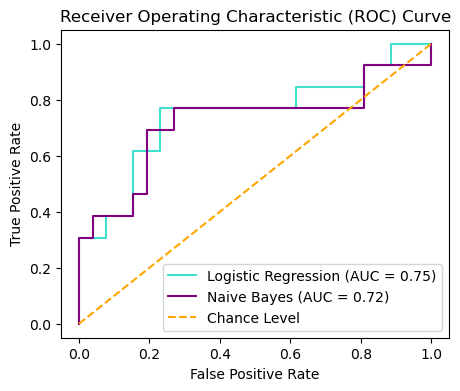

In [135]:
# Plot ROC graph
#Reference [10]

plt.figure(figsize=(5, 4))

plt.plot(Reg_fpr, Reg_tpr, color='turquoise', label=f'Logistic Regression (AUC = {round(Reg_ROC_AUC,2)})')
plt.plot(NB_fpr, NB_tpr, color='purple', label=f'Naive Bayes (AUC = {round(NB_ROC_AUC,2)})')

plt.plot([0, 1], [0, 1], color='orange', linestyle='--', label='Chance Level')


plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Evaluation Comparisons

The models were run 5 times and the performance evaluations for accuracy, F1 score, and ROC score were recorded.

**Accuracy**

| S/N    |	Logistic Regression	|  Naïve Bayes |
|:------:|:--------------------:|:------------:|
|1       |     0.69             |  0.67        |
|--------|----------------------|--------------|
|2	     |     0.77	            |  0.77        |
|--------|----------------------|--------------|
|3	     |     0.77	            |  0.72        |
|--------|----------------------|--------------|
|4	     |     0.72	            |  0.67        |
|--------|----------------------|--------------|
|5	     |     0.77	            |  0.72        |


**F1_Score**

| S/N    |	Logistic Regression	|  Naïve Bayes |
|:------:|:--------------------:|:------------:|
|1       |     0.60             |  0.58        |
|--------|----------------------|--------------|
|2	     |     0.74	            |  0.71        |
|--------|----------------------|--------------|
|3	     |     0.71	            |  0.59        |
|--------|----------------------|--------------|
|4	     |     0.67	            |  0.61        |
|--------|----------------------|--------------|
|5	     |     0.64	            |  0.52        |


**ROC Score**

| S/N    |	Logistic Regression	|  Naïve Bayes |
|:------:|:--------------------:|:------------:|
|1       |     0.78             |  0.77        |
|--------|----------------------|--------------|
|2	     |     0.90	            |  0.88        |
|--------|----------------------|--------------|
|3	     |     0.84	            |  0.79        |
|--------|----------------------|--------------|
|4	     |     0.76	            |  0.71        |
|--------|----------------------|--------------|
|5	     |     0.75	            |  0.72        |


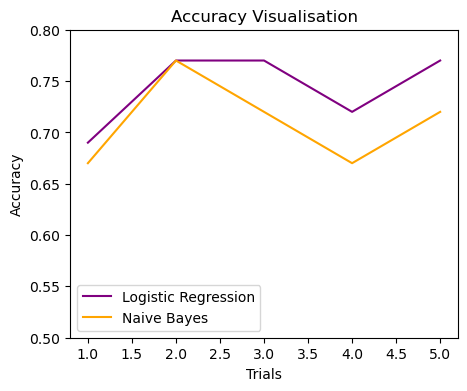

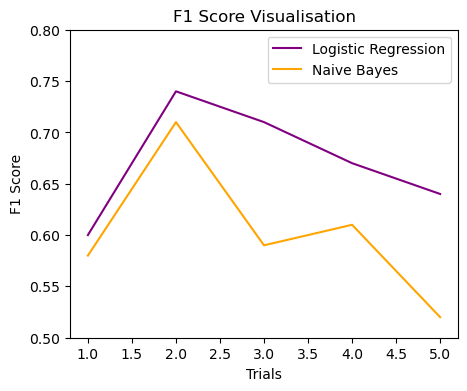

In [3]:
#The Accuracy and F1 Scores are visualised in this section

Reg_accuracy_values = [0.69, 0.77, 0.77, 0.72, 0.77] #Logistic Regression accuracy values
NB_accuracy_values = [0.67, 0.77, 0.72, 0.67, 0.72] #Naive Bayes accuracy values

Reg_f1_values = [0.60, 0.74, 0.71, 0.67, 0.64] #Logistic Regression F1 values
NB_f1_values = [0.58, 0.71, 0.59, 0.61, 0.52] #Naive Bayes F1 values

trials = [1, 2, 3, 4, 5] #Trials

#Function to plot the graphs.
def plots(Reg_values, NB_values, trials, ylabel, title):
    plt.figure(figsize=(5, 4))
    plt.plot(trials, Reg_values, label="Logistic Regression", color="purple")
    plt.plot(trials, NB_values, label="Naive Bayes", color="orange")
    plt.xlabel("Trials")
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.ylim(0.5,0.8)
    plt.show()


plots(Reg_accuracy_values, NB_accuracy_values, trials, "Accuracy", "Accuracy Visualisation") #Accuracy plot
plots(Reg_f1_values, NB_f1_values, trials, "F1 Score", "F1 Score Visualisation") #F1 score plot

# Conclusion

From the evaluation of the performance of the Naïve Bayes and Logistic Regression models, it is observed that the logistic regression model performed better in accuracy, confusion matrix and f1 score, and ROC-AUC score. There are several factors that could contribute to this performance:

•	Naïve Bayes assumption of feature independence: assumptions that may not always hold for all datasets. This can lead to underperformance of the model if some of the features are correlated.

•	The probabilities calculated in the Naïve Bayes model is based on the observations from the training data. This would mean that the presence of outliers can have a negative impact on the model’s performance. 

•	The Logistic Regression model is able to adjust/optimise its coefficients during training. This allows the model to adapt to patterns in the data. Therefore, contributing to a better performance. 

In conclusion, the performance of the Logistic Regression model lies in its ability to handle correlated features, its robustness in the presence of outliers.

# References

[1] https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

[2] https://pandas.pydata.org/docs/reference/api/pandas.Series.reset_index.html

[3] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

[4] J. Ren, S. D. Lee, X. Chen, B. Kao, R. Cheng and D. Cheung, "Naive Bayes Classification of Uncertain Data," 2009 Ninth IEEE International Conference on Data Mining, Miami Beach, FL, USA, 2009, pp. 944-949, doi: 10.1109/ICDM.2009.90.

[5] https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

[6] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

[7] https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

[8] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

[9] https://jupyterbook.org/en/stable/content/math.html

[10] https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

[11] https://seaborn.pydata.org/generated/seaborn.regplot.html

[12] https://jupyterbook.org/en/stable/content/math.html